## Time Series Pred: Milk production data
https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line

** Dataset Information: **

Monthly milk production during Jan 62 - Dec 75

** Attribute Information: **

- Month 
- milk production (pounds per cow). Jan 62 - Dec 75

** Objective of this project **

predict the last 12 months milk production based on the data during the previous period

## Data

In [29]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')

# Load Data
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [30]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


### Data Clean

In [31]:
# clean data
df.drop(168,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Milk in pounds per cow']
df.set_index('Month',inplace=True)
df.tail()

,Milk in pounds per cow
Month,
1975-08-01,858.0
1975-09-01,817.0
1975-10-01,827.0
1975-11-01,797.0
1975-12-01,843.0


In [32]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Milk in pounds per cow,168.0,754.708333,102.204524,553.0,677.75,761.0,824.5,969.0


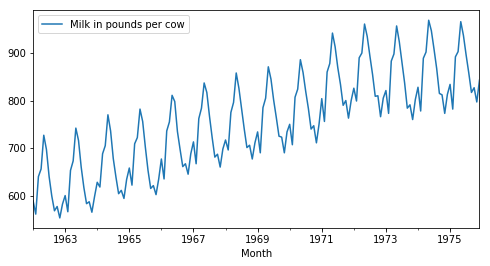

In [33]:
df.plot(figsize=(8,4))

### ETS Decomposition

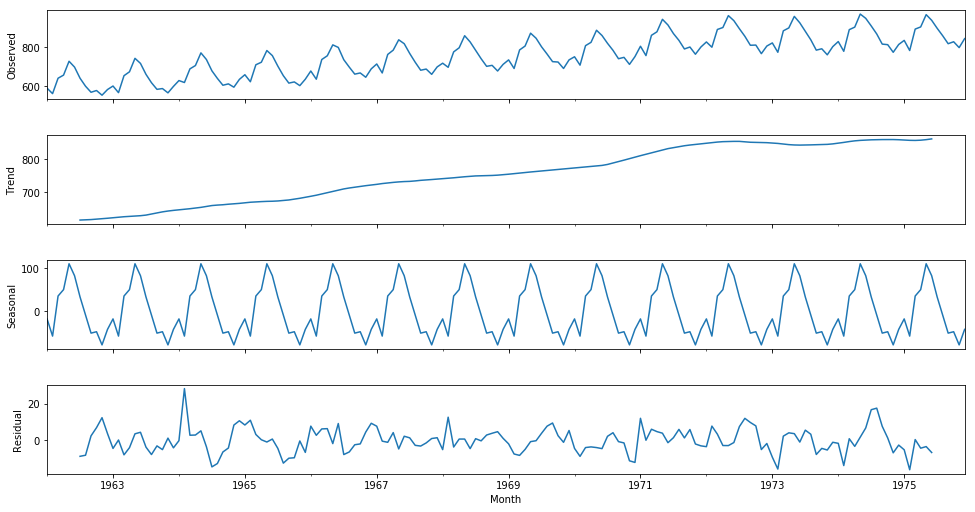

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df['Milk in pounds per cow'], freq=12)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

### Stationary Data

In [35]:
# Augmented Dickey-Fuller test 
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        
        
adf_check(df['Milk in pounds per cow'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.30381158742
p-value : 0.627426708603
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.05499555865
p-value : 0.0300680040018
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


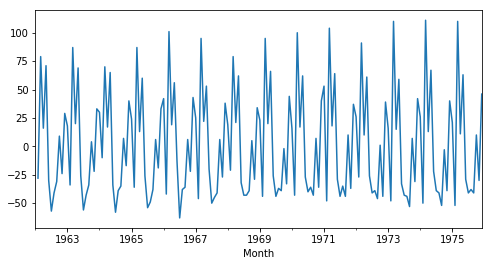

In [38]:
# First Difference
df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)
df['Milk First Difference'].plot(figsize=(8,4))
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -5.03800227492
p-value : 1.86542343188e-05
#Lags Used : 11
Number of Observations Used : 143
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


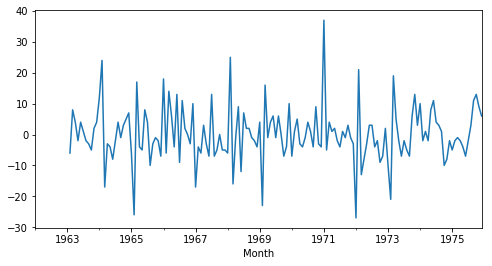

In [40]:
# Seasonal First Difference
df['Seasonal First Difference'] = df['Milk First Difference'] - df['Milk First Difference'].shift(12)
df['Seasonal First Difference'].plot(figsize=(8,4))
adf_check(df['Seasonal First Difference'].dropna())

### Autoregression

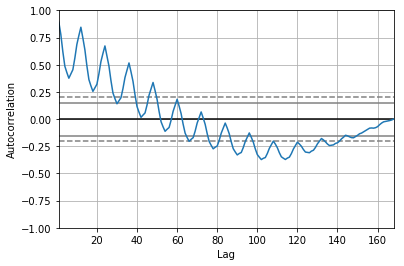

In [42]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['Milk in pounds per cow'])

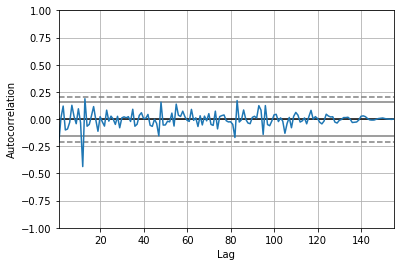

In [43]:
autocorrelation_plot(df['Seasonal First Difference'].dropna())

## Persistence Model (baseline)


Test MSE: 2341.500


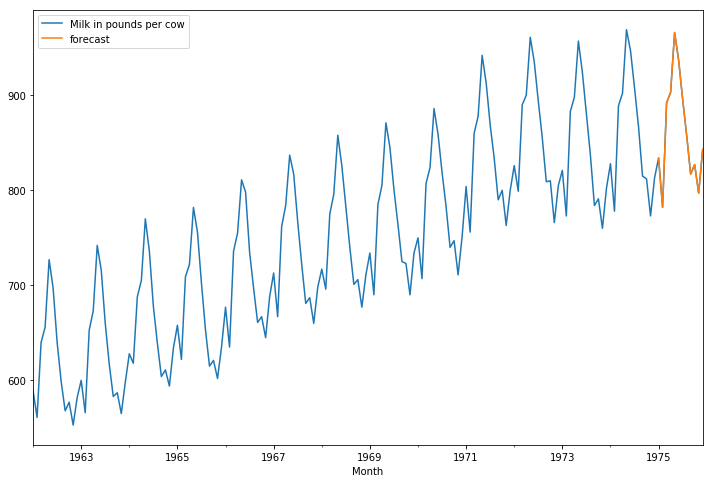

In [73]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline
warnings.filterwarnings('ignore')

# Load & Clean Data
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.drop(168,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Milk in pounds per cow']
df.set_index('Month',inplace=True)
#print(df.head())

# Data Preprocessing
#lagged dataset
df['Milk in pounds per cow, t-1'] = df['Milk in pounds per cow'].shift(1)
df['Milk in pounds per cow, t+1'] = df['Milk in pounds per cow']
#print(df.head()) 

#train test set
X = df.values
train, test = X[1:-12], X[-12:]
X_train, y_train = train[:,0], train[:,1]
X_test, y_test = test[:,0], test[:,1]

# Persistence model
def model_persistence(x):
    return x

# Make predictions & Evaluate model
y_pred = list()
for x in X_test:
    yhat = model_persistence(x)
    y_pred.append(yhat)
test_score = mean_squared_error(y_test, y_pred)
print('\nTest MSE: %.3f' % test_score)

# Visualize results
df['forecast'] = np.nan
df['forecast'][-12:]  = y_pred
#df.tail(13)
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

## Autoregressive Integrated Moving Average (ARIMA) Model

                                 Statespace Model Results                                 
Dep. Variable:             Milk in pounds per cow   No. Observations:                  156
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -495.919
Date:                            Sat, 03 Mar 2018   AIC                            997.837
Time:                                    22:30:48   BIC                           1006.987
Sample:                                01-01-1962   HQIC                          1001.553
                                     - 12-01-1974                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0326      0.112     -0.292      0.770      -0.252       0.187
ma.S.L12      -0.5936      0.109   

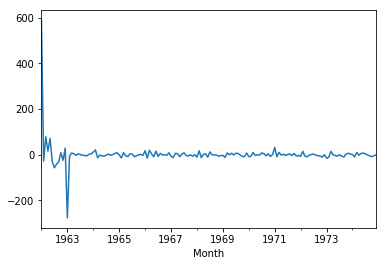

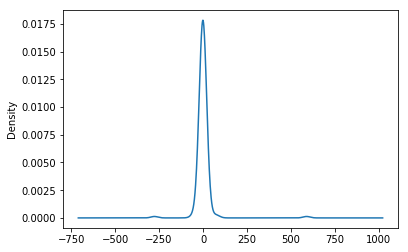

In [77]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
warnings.filterwarnings('ignore')

# Load & Clean Data
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.drop(168,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.columns = ['Month','Milk in pounds per cow']
df.set_index('Month',inplace=True)
#print(df.head())

# Fit seasonal ARIMA model
#from statsmodels.tsa.arima_model import ARIMA #--> for non-seasonal data
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'][:-12],
                                  order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())
results.resid.plot()
plt.show()
results.resid.plot(kind='kde')
plt.show()

Test MSE: 113.475


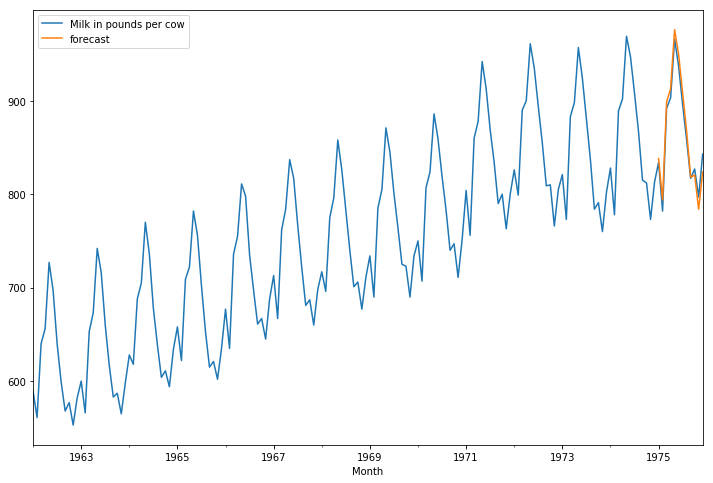

In [80]:
# forecast
df['forecast'] = results.predict(start = 156, end= 168, dynamic= True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))
df.tail(13)
# rmse
error = mean_squared_error(df['Milk in pounds per cow'][-12:],
                           df['forecast'][-12:])
print('Test MSE: %.3f' % error)